In [12]:
import numpy as np

#实现一个类似深度学习库
#与tensorflow 类似
#节点，

#神经元
class Node:
    # 该类为所有其他图节点类的父类
    def __init__(self, inputs=[]):
        #定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        #每个节点都是其输入节点的输出节点
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None
        
        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented
        
class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        #定义节点数值
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            #以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        #前向 即为sigmoid函数计算
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        #反向传播计算梯度
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [13]:
from sklearn.datasets import load_boston

In [14]:
data = load_boston()

In [15]:
losses = []

In [16]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 182.904
Epoch: 101, Loss: 7.070
Epoch: 201, Loss: 5.246
Epoch: 301, Loss: 5.139
Epoch: 401, Loss: 4.628
Epoch: 501, Loss: 4.068
Epoch: 601, Loss: 4.633
Epoch: 701, Loss: 3.915
Epoch: 801, Loss: 3.781
Epoch: 901, Loss: 4.142
Epoch: 1001, Loss: 4.003
Epoch: 1101, Loss: 3.656
Epoch: 1201, Loss: 4.038
Epoch: 1301, Loss: 3.493
Epoch: 1401, Loss: 3.258
Epoch: 1501, Loss: 2.983
Epoch: 1601, Loss: 3.241
Epoch: 1701, Loss: 3.154
Epoch: 1801, Loss: 3.019
Epoch: 1901, Loss: 3.141
Epoch: 2001, Loss: 3.649
Epoch: 2101, Loss: 3.637
Epoch: 2201, Loss: 2.688
Epoch: 2301, Loss: 2.949
Epoch: 2401, Loss: 2.962
Epoch: 2501, Loss: 3.200
Epoch: 2601, Loss: 2.451
Epoch: 2701, Loss: 2.726
Epoch: 2801, Loss: 3.504
Epoch: 2901, Loss: 2.725
Epoch: 3001, Loss: 2.564
Epoch: 3101, Loss: 3.173
Epoch: 3201, Loss: 3.046
Epoch: 3301, Loss: 2.936
Epoch: 3401, Loss: 2.704
Epoch: 3501, Loss: 3.020
Epoch: 3601, Loss: 2.762
Epoch: 3701, Loss: 2.921
Epoch: 3801, Loss: 2.858
Epoc

In [17]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [18]:
forward(l2,graph)

array([[35.95431521],
       [19.33819675],
       [16.96920688],
       [21.13237402],
       [18.02981304],
       [41.20997679],
       [23.95639448],
       [20.39805349],
       [21.81039436],
       [28.78229079],
       [21.19786285],
       [20.32407609],
       [14.85026809],
       [16.05037135],
       [16.36869955],
       [27.53843983]])

In [19]:
import matplotlib.pyplot as plt

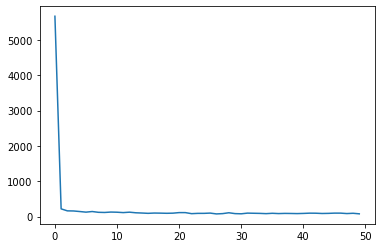

In [20]:
plt.plot(range(len(losses)), losses)

In [21]:
W2.value

array([[ 4.53188855],
       [ 8.96419946],
       [ 6.36400519],
       [ 8.68160027],
       [14.11233694],
       [ 5.47779314],
       [ 7.26105914],
       [ 8.73770696],
       [ 3.94339595],
       [16.90198923]])

In [22]:
X_ = data['data']

In [23]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [24]:
import keras

Using TensorFlow backend.


In [25]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [26]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [27]:
model.fit(X_, y_, epochs=5000, batch_size=32)


Epoch 1/5000
506/506 [==============================] - 0s 162us/step - loss: 137.9479 - mse: 137.9480
Epoch 2/5000
506/506 [==============================] - 0s 20us/step - loss: 82.1378 - mse: 82.1378
Epoch 3/5000
506/506 [==============================] - 0s 22us/step - loss: 80.2618 - mse: 80.2618
Epoch 4/5000
506/506 [==============================] - 0s 24us/step - loss: 81.4521 - mse: 81.4521
Epoch 5/5000
506/506 [==============================] - 0s 22us/step - loss: 76.8073 - mse: 76.8073
Epoch 6/5000
506/506 [==============================] - 0s 22us/step - loss: 73.1522 - mse: 73.1522
Epoch 7/5000
506/506 [==============================] - 0s 22us/step - loss: 82.9480 - mse: 82.9480
Epoch 8/5000
506/506 [==============================] - 0s 22us/step - loss: 78.3513 - mse: 78.3513
Epoch 9/5000
506/506 [==============================] - 0s 22us/step - loss: 83.9963 - mse: 83.9963
Epoch 10/5000
506/506 [==============================] - 0s 22us/step - loss: 85.7410 - mse: 85.

506/506 [==============================] - 0s 20us/step - loss: 85.4345 - mse: 85.4345
Epoch 81/5000
506/506 [==============================] - 0s 22us/step - loss: 84.6968 - mse: 84.6967
Epoch 82/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0364 - mse: 85.0364
Epoch 83/5000
506/506 [==============================] - 0s 18us/step - loss: 85.8286 - mse: 85.8286
Epoch 84/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5120 - mse: 85.5120
Epoch 85/5000
506/506 [==============================] - 0s 22us/step - loss: 85.3754 - mse: 85.3754
Epoch 86/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0704 - mse: 85.0704
Epoch 87/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0110 - mse: 85.0110
Epoch 88/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1873 - mse: 85.1873
Epoch 89/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2717 - mse: 85.2717
Epoc

506/506 [==============================] - 0s 20us/step - loss: 85.0298 - mse: 85.0298
Epoch 241/5000
506/506 [==============================] - 0s 20us/step - loss: 85.8393 - mse: 85.8393
Epoch 242/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6741 - mse: 84.6741
Epoch 243/5000
506/506 [==============================] - 0s 22us/step - loss: 85.6952 - mse: 85.6952
Epoch 244/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2030 - mse: 85.2030
Epoch 245/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6586 - mse: 84.6586
Epoch 246/5000
506/506 [==============================] - 0s 22us/step - loss: 85.7873 - mse: 85.7873
Epoch 247/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8960 - mse: 84.8960
Epoch 248/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1025 - mse: 85.1025
Epoch 249/5000
506/506 [==============================] - 0s 20us/step - loss: 85.3034 - mse: 85.

506/506 [==============================] - 0s 18us/step - loss: 85.6712 - mse: 85.6712
Epoch 400/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8699 - mse: 84.8699
Epoch 401/5000
506/506 [==============================] - 0s 20us/step - loss: 85.6018 - mse: 85.6018
Epoch 402/5000
506/506 [==============================] - 0s 22us/step - loss: 84.4900 - mse: 84.4900
Epoch 403/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1567 - mse: 85.1567
Epoch 404/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7805 - mse: 84.7805
Epoch 405/5000
506/506 [==============================] - 0s 22us/step - loss: 85.4716 - mse: 85.4716
Epoch 406/5000
506/506 [==============================] - 0s 20us/step - loss: 85.4428 - mse: 85.4428
Epoch 407/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8503 - mse: 84.8503
Epoch 408/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8511 - mse: 84.

506/506 [==============================] - 0s 20us/step - loss: 85.4812 - mse: 85.4812
Epoch 558/5000
506/506 [==============================] - 0s 20us/step - loss: 85.3277 - mse: 85.3277
Epoch 559/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0239 - mse: 85.0239
Epoch 560/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8893 - mse: 84.8893
Epoch 561/5000
506/506 [==============================] - 0s 22us/step - loss: 85.1488 - mse: 85.1488
Epoch 562/5000
506/506 [==============================] - 0s 22us/step - loss: 85.4410 - mse: 85.4410
Epoch 563/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9209 - mse: 84.9209
Epoch 564/5000
506/506 [==============================] - 0s 22us/step - loss: 85.1846 - mse: 85.1846
Epoch 565/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8644 - mse: 84.8644
Epoch 566/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6845 - mse: 84.

506/506 [==============================] - 0s 22us/step - loss: 84.6866 - mse: 84.6866
Epoch 716/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0197 - mse: 85.0197
Epoch 717/5000
506/506 [==============================] - 0s 22us/step - loss: 84.9857 - mse: 84.9857
Epoch 718/5000
506/506 [==============================] - 0s 22us/step - loss: 85.1953 - mse: 85.1953
Epoch 719/5000
506/506 [==============================] - 0s 18us/step - loss: 85.2809 - mse: 85.2809
Epoch 720/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8367 - mse: 84.8367
Epoch 721/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1268 - mse: 85.1268
Epoch 722/5000
506/506 [==============================] - 0s 18us/step - loss: 84.7923 - mse: 84.7923
Epoch 723/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2981 - mse: 85.2981
Epoch 724/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7913 - mse: 84.

506/506 [==============================] - 0s 20us/step - loss: 84.6967 - mse: 84.6967
Epoch 796/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9200 - mse: 84.9200
Epoch 797/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7361 - mse: 84.7361
Epoch 798/5000
506/506 [==============================] - 0s 20us/step - loss: 85.8734 - mse: 85.8734
Epoch 799/5000
506/506 [==============================] - 0s 18us/step - loss: 85.8413 - mse: 85.8413
Epoch 800/5000
506/506 [==============================] - 0s 22us/step - loss: 85.1399 - mse: 85.1399
Epoch 801/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1367 - mse: 85.1367
Epoch 802/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8369 - mse: 84.8369
Epoch 803/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1071 - mse: 85.1071
Epoch 804/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9411 - mse: 84.

506/506 [==============================] - 0s 20us/step - loss: 85.1554 - mse: 85.1554
Epoch 876/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1869 - mse: 85.1869
Epoch 877/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1113 - mse: 85.1114
Epoch 878/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5542 - mse: 85.5542
Epoch 879/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1431 - mse: 85.1431
Epoch 880/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5323 - mse: 84.5323
Epoch 881/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0978 - mse: 85.0978
Epoch 882/5000
506/506 [==============================] - 0s 20us/step - loss: 85.3581 - mse: 85.3581
Epoch 883/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9005 - mse: 84.9005
Epoch 884/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5030 - mse: 85.

506/506 [==============================] - 0s 20us/step - loss: 85.1035 - mse: 85.1035
Epoch 1036/5000
506/506 [==============================] - 0s 20us/step - loss: 85.4884 - mse: 85.4884
Epoch 1037/5000
506/506 [==============================] - ETA: 0s - loss: 70.0309 - mse: 70.030 - 0s 20us/step - loss: 84.5669 - mse: 84.5669
Epoch 1038/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1381 - mse: 85.1381
Epoch 1039/5000
506/506 [==============================] - 0s 18us/step - loss: 85.0112 - mse: 85.0112
Epoch 1040/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6187 - mse: 84.6187
Epoch 1041/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7695 - mse: 84.7695
Epoch 1042/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7941 - mse: 84.7941
Epoch 1043/5000
506/506 [==============================] - 0s 20us/step - loss: 84.4480 - mse: 84.4480
Epoch 1044/5000
506/506 [========================

506/506 [==============================] - 0s 24us/step - loss: 84.9244 - mse: 84.9244
Epoch 1194/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9653 - mse: 84.9653
Epoch 1195/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7536 - mse: 84.7536
Epoch 1196/5000
506/506 [==============================] - 0s 22us/step - loss: 85.1503 - mse: 85.1503
Epoch 1197/5000
506/506 [==============================] - 0s 22us/step - loss: 85.2435 - mse: 85.2435
Epoch 1198/5000
506/506 [==============================] - 0s 24us/step - loss: 85.1032 - mse: 85.1032
Epoch 1199/5000
506/506 [==============================] - 0s 24us/step - loss: 84.7178 - mse: 84.7178
Epoch 1200/5000
506/506 [==============================] - 0s 22us/step - loss: 85.9099 - mse: 85.9099
Epoch 1201/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9138 - mse: 84.9138
Epoch 1202/5000
506/506 [==============================] - 0s 22us/step - loss: 84.6968 -

506/506 [==============================] - 0s 20us/step - loss: 84.8167 - mse: 84.8167
Epoch 1352/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7680 - mse: 84.7680
Epoch 1353/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0339 - mse: 85.0339
Epoch 1354/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7249 - mse: 84.7249
Epoch 1355/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7668 - mse: 84.7668
Epoch 1356/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1473 - mse: 85.1473
Epoch 1357/5000
506/506 [==============================] - 0s 22us/step - loss: 85.5136 - mse: 85.5136
Epoch 1358/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1385 - mse: 85.1385
Epoch 1359/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8447 - mse: 84.8447
Epoch 1360/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9759 -

506/506 [==============================] - 0s 20us/step - loss: 84.8783 - mse: 84.8783
Epoch 1510/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8015 - mse: 84.8015
Epoch 1511/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1891 - mse: 85.1891
Epoch 1512/5000
506/506 [==============================] - 0s 20us/step - loss: 85.4604 - mse: 85.4604
Epoch 1513/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0103 - mse: 85.0103
Epoch 1514/5000
506/506 [==============================] - ETA: 0s - loss: 46.8985 - mse: 46.898 - 0s 20us/step - loss: 84.8917 - mse: 84.8917
Epoch 1515/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6369 - mse: 84.6369
Epoch 1516/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9642 - mse: 84.9642
Epoch 1517/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9307 - mse: 84.9307
Epoch 1518/5000
506/506 [========================

506/506 [==============================] - 0s 20us/step - loss: 84.6471 - mse: 84.6471
Epoch 1668/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1554 - mse: 85.1554
Epoch 1669/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0163 - mse: 85.0163
Epoch 1670/5000
506/506 [==============================] - 0s 22us/step - loss: 84.9004 - mse: 84.9004
Epoch 1671/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8451 - mse: 84.8451
Epoch 1672/5000
506/506 [==============================] - 0s 20us/step - loss: 84.4245 - mse: 84.4245
Epoch 1673/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0860 - mse: 85.0860
Epoch 1674/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6398 - mse: 84.6398
Epoch 1675/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9866 - mse: 84.9866
Epoch 1676/5000
506/506 [==============================] - 0s 24us/step - loss: 84.7666 -

506/506 [==============================] - 0s 20us/step - loss: 84.8771 - mse: 84.8771
Epoch 1826/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6009 - mse: 84.6009
Epoch 1827/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9009 - mse: 84.9009
Epoch 1828/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2695 - mse: 85.2694
Epoch 1829/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8118 - mse: 84.8118
Epoch 1830/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7204 - mse: 84.7204
Epoch 1831/5000
506/506 [==============================] - 0s 20us/step - loss: 84.4910 - mse: 84.4910
Epoch 1832/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1014 - mse: 85.1014
Epoch 1833/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5165 - mse: 84.5165
Epoch 1834/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8170 -

506/506 [==============================] - 0s 20us/step - loss: 84.9755 - mse: 84.9755
Epoch 1984/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0262 - mse: 85.0262
Epoch 1985/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9029 - mse: 84.9029
Epoch 1986/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0223 - mse: 85.0223
Epoch 1987/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9336 - mse: 84.9336
Epoch 1988/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6731 - mse: 84.6731
Epoch 1989/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5128 - mse: 85.5128
Epoch 1990/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9810 - mse: 84.9810
Epoch 1991/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9794 - mse: 84.9794
Epoch 1992/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9973 -

506/506 [==============================] - 0s 22us/step - loss: 84.7946 - mse: 84.7946
Epoch 2142/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7583 - mse: 84.7584
Epoch 2143/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5153 - mse: 85.5154
Epoch 2144/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2369 - mse: 85.2369
Epoch 2145/5000
506/506 [==============================] - 0s 22us/step - loss: 85.7021 - mse: 85.7021
Epoch 2146/5000
506/506 [==============================] - 0s 24us/step - loss: 85.1781 - mse: 85.1781
Epoch 2147/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5147 - mse: 85.5147
Epoch 2148/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0573 - mse: 85.0573
Epoch 2149/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2461 - mse: 85.2461
Epoch 2150/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9094 -

506/506 [==============================] - 0s 20us/step - loss: 84.6784 - mse: 84.6784
Epoch 2300/5000
506/506 [==============================] - 0s 18us/step - loss: 85.8193 - mse: 85.8193
Epoch 2301/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8472 - mse: 84.8472
Epoch 2302/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8856 - mse: 84.8856
Epoch 2303/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1685 - mse: 85.1685
Epoch 2304/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0151 - mse: 85.0151
Epoch 2305/5000
506/506 [==============================] - 0s 22us/step - loss: 84.3291 - mse: 84.3291
Epoch 2306/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5159 - mse: 85.5159
Epoch 2307/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8359 - mse: 84.8359
Epoch 2308/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6121 -

506/506 [==============================] - 0s 20us/step - loss: 85.1387 - mse: 85.1387
Epoch 2458/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9506 - mse: 84.9506
Epoch 2459/5000
506/506 [==============================] - 0s 22us/step - loss: 85.2330 - mse: 85.2331
Epoch 2460/5000
506/506 [==============================] - 0s 22us/step - loss: 84.4610 - mse: 84.4610
Epoch 2461/5000
506/506 [==============================] - 0s 18us/step - loss: 85.2824 - mse: 85.2824
Epoch 2462/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7731 - mse: 84.7731
Epoch 2463/5000
506/506 [==============================] - 0s 20us/step - loss: 84.2321 - mse: 84.2321
Epoch 2464/5000
506/506 [==============================] - 0s 18us/step - loss: 85.5830 - mse: 85.5830
Epoch 2465/5000
506/506 [==============================] - 0s 20us/step - loss: 85.4614 - mse: 85.4614
Epoch 2466/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0611 -

506/506 [==============================] - 0s 20us/step - loss: 84.6649 - mse: 84.6649
Epoch 2616/5000
506/506 [==============================] - 0s 24us/step - loss: 85.3043 - mse: 85.3043
Epoch 2617/5000
506/506 [==============================] - 0s 26us/step - loss: 85.3327 - mse: 85.3327
Epoch 2618/5000
506/506 [==============================] - 0s 20us/step - loss: 84.3018 - mse: 84.3018
Epoch 2619/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1964 - mse: 85.1964
Epoch 2620/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7212 - mse: 84.7213
Epoch 2621/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1347 - mse: 85.1347
Epoch 2622/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9757 - mse: 84.9757
Epoch 2623/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0014 - mse: 85.0014
Epoch 2624/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1799 -

506/506 [==============================] - 0s 18us/step - loss: 84.6662 - mse: 84.6662
Epoch 2774/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9404 - mse: 84.9404
Epoch 2775/5000
506/506 [==============================] - 0s 26us/step - loss: 84.9060 - mse: 84.9060
Epoch 2776/5000
506/506 [==============================] - 0s 26us/step - loss: 85.2562 - mse: 85.2562
Epoch 2777/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0844 - mse: 85.0844
Epoch 2778/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5695 - mse: 85.5695
Epoch 2779/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9267 - mse: 84.9267
Epoch 2780/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9497 - mse: 84.9497
Epoch 2781/5000
506/506 [==============================] - 0s 22us/step - loss: 84.6710 - mse: 84.6710
Epoch 2782/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7351 -

506/506 [==============================] - 0s 20us/step - loss: 85.0133 - mse: 85.0133
Epoch 2932/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9716 - mse: 84.9716
Epoch 2933/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9313 - mse: 84.9313
Epoch 2934/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9613 - mse: 84.9613
Epoch 2935/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8828 - mse: 84.8828
Epoch 2936/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8468 - mse: 84.8467
Epoch 2937/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1455 - mse: 85.1455
Epoch 2938/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8035 - mse: 84.8035
Epoch 2939/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1629 - mse: 85.1629
Epoch 2940/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8199 -

506/506 [==============================] - 0s 20us/step - loss: 85.0412 - mse: 85.0412
Epoch 3090/5000
506/506 [==============================] - 0s 18us/step - loss: 84.6526 - mse: 84.6526
Epoch 3091/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0406 - mse: 85.0406
Epoch 3092/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7969 - mse: 84.7969
Epoch 3093/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7063 - mse: 84.7063
Epoch 3094/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0165 - mse: 85.0165
Epoch 3095/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5879 - mse: 84.5879
Epoch 3096/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8208 - mse: 84.8208
Epoch 3097/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1797 - mse: 85.1797
Epoch 3098/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8437 -

506/506 [==============================] - 0s 20us/step - loss: 84.6761 - mse: 84.6761
Epoch 3248/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1431 - mse: 85.1431
Epoch 3249/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7286 - mse: 84.7286
Epoch 3250/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9899 - mse: 84.9899
Epoch 3251/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8519 - mse: 84.8519
Epoch 3252/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5039 - mse: 84.5039
Epoch 3253/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0877 - mse: 85.0877
Epoch 3254/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9742 - mse: 84.9742
Epoch 3255/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6854 - mse: 84.6854
Epoch 3256/5000
506/506 [==============================] - ETA: 0s - loss: 97.3731 - mse:

506/506 [==============================] - 0s 20us/step - loss: 84.8976 - mse: 84.8976
Epoch 3405/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8088 - mse: 84.8088
Epoch 3406/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1363 - mse: 85.1363
Epoch 3407/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1742 - mse: 85.1742
Epoch 3408/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9189 - mse: 84.9189
Epoch 3409/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8800 - mse: 84.8800
Epoch 3410/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6565 - mse: 84.6565
Epoch 3411/5000
506/506 [==============================] - 0s 18us/step - loss: 84.5887 - mse: 84.5887
Epoch 3412/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9612 - mse: 84.9612
Epoch 3413/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8924 -

506/506 [==============================] - 0s 24us/step - loss: 84.7195 - mse: 84.7195
Epoch 3562/5000
506/506 [==============================] - 0s 26us/step - loss: 85.2175 - mse: 85.2175
Epoch 3563/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9736 - mse: 84.9736
Epoch 3564/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8571 - mse: 84.8571
Epoch 3565/5000
506/506 [==============================] - 0s 24us/step - loss: 84.6111 - mse: 84.6111
Epoch 3566/5000
506/506 [==============================] - 0s 26us/step - loss: 84.6148 - mse: 84.6148
Epoch 3567/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7181 - mse: 84.7181
Epoch 3568/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2425 - mse: 85.2425
Epoch 3569/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7274 - mse: 84.7274
Epoch 3570/5000
506/506 [==============================] - 0s 22us/step - loss: 85.3463 -

506/506 [==============================] - 0s 20us/step - loss: 84.9441 - mse: 84.9441
Epoch 3720/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5929 - mse: 84.5929
Epoch 3721/5000
506/506 [==============================] - 0s 22us/step - loss: 84.1618 - mse: 84.1618
Epoch 3722/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1850 - mse: 85.1850
Epoch 3723/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2002 - mse: 85.2002
Epoch 3724/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9320 - mse: 84.9320
Epoch 3725/5000
506/506 [==============================] - 0s 18us/step - loss: 84.7714 - mse: 84.7714
Epoch 3726/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8133 - mse: 84.8133
Epoch 3727/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7587 - mse: 84.7587
Epoch 3728/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1478 -

506/506 [==============================] - 0s 22us/step - loss: 84.6005 - mse: 84.6005
Epoch 3878/5000
506/506 [==============================] - 0s 22us/step - loss: 84.8408 - mse: 84.8408
Epoch 3879/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7634 - mse: 84.7635
Epoch 3880/5000
506/506 [==============================] - 0s 20us/step - loss: 85.4271 - mse: 85.4271
Epoch 3881/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2526 - mse: 85.2526
Epoch 3882/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8762 - mse: 84.8762
Epoch 3883/5000
506/506 [==============================] - 0s 22us/step - loss: 84.6249 - mse: 84.6249
Epoch 3884/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6400 - mse: 84.6400
Epoch 3885/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6969 - mse: 84.6969
Epoch 3886/5000
506/506 [==============================] - 0s 22us/step - loss: 84.7867 -

506/506 [==============================] - 0s 22us/step - loss: 85.0244 - mse: 85.0244
Epoch 4036/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9792 - mse: 84.9792
Epoch 4037/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1941 - mse: 85.1941
Epoch 4038/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8080 - mse: 84.8080
Epoch 4039/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8065 - mse: 84.8065
Epoch 4040/5000
506/506 [==============================] - 0s 18us/step - loss: 85.0857 - mse: 85.0857
Epoch 4041/5000
506/506 [==============================] - 0s 22us/step - loss: 84.5221 - mse: 84.5221
Epoch 4042/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1643 - mse: 85.1643
Epoch 4043/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9473 - mse: 84.9473
Epoch 4044/5000
506/506 [==============================] - 0s 20us/step - loss: 85.2985 -

506/506 [==============================] - 0s 20us/step - loss: 84.9481 - mse: 84.9481
Epoch 4194/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1276 - mse: 85.1276
Epoch 4195/5000
506/506 [==============================] - 0s 22us/step - loss: 84.5734 - mse: 84.5734
Epoch 4196/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8187 - mse: 84.8187
Epoch 4197/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0811 - mse: 85.0811
Epoch 4198/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1117 - mse: 85.1117
Epoch 4199/5000
506/506 [==============================] - 0s 20us/step - loss: 84.4521 - mse: 84.4520
Epoch 4200/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9668 - mse: 84.9668
Epoch 4201/5000
506/506 [==============================] - 0s 18us/step - loss: 84.6039 - mse: 84.6039
Epoch 4202/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0365 -

506/506 [==============================] - 0s 20us/step - loss: 84.9392 - mse: 84.9392
Epoch 4352/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9156 - mse: 84.9156
Epoch 4353/5000
506/506 [==============================] - 0s 20us/step - loss: 84.6084 - mse: 84.6084
Epoch 4354/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9075 - mse: 84.9075
Epoch 4355/5000
506/506 [==============================] - 0s 24us/step - loss: 85.0233 - mse: 85.0233
Epoch 4356/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7981 - mse: 84.7981
Epoch 4357/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9353 - mse: 84.9353
Epoch 4358/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0541 - mse: 85.0541
Epoch 4359/5000
506/506 [==============================] - 0s 18us/step - loss: 84.7344 - mse: 84.7344
Epoch 4360/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1284 -

506/506 [==============================] - 0s 20us/step - loss: 84.8953 - mse: 84.8953
Epoch 4510/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9215 - mse: 84.9214
Epoch 4511/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8415 - mse: 84.8415
Epoch 4512/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0179 - mse: 85.0178
Epoch 4513/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5904 - mse: 84.5904
Epoch 4514/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1790 - mse: 85.1790
Epoch 4515/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1380 - mse: 85.1380
Epoch 4516/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8482 - mse: 84.8482
Epoch 4517/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5454 - mse: 84.5454
Epoch 4518/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9941 -

506/506 [==============================] - 0s 20us/step - loss: 84.7343 - mse: 84.7343
Epoch 4668/5000
506/506 [==============================] - 0s 18us/step - loss: 85.0894 - mse: 85.0894
Epoch 4669/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9243 - mse: 84.9243
Epoch 4670/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8796 - mse: 84.8796
Epoch 4671/5000
506/506 [==============================] - 0s 22us/step - loss: 85.2669 - mse: 85.2669
Epoch 4672/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5245 - mse: 84.5245
Epoch 4673/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9532 - mse: 84.9532
Epoch 4674/5000
506/506 [==============================] - 0s 20us/step - loss: 85.3207 - mse: 85.3207
Epoch 4675/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0543 - mse: 85.0542
Epoch 4676/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8706 -

506/506 [==============================] - 0s 18us/step - loss: 84.7774 - mse: 84.7774
Epoch 4825/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9002 - mse: 84.9002
Epoch 4826/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1338 - mse: 85.1338
Epoch 4827/5000
506/506 [==============================] - 0s 18us/step - loss: 84.8519 - mse: 84.8519
Epoch 4828/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7992 - mse: 84.7992
Epoch 4829/5000
506/506 [==============================] - 0s 18us/step - loss: 85.1786 - mse: 85.1786
Epoch 4830/5000
506/506 [==============================] - 0s 18us/step - loss: 84.6831 - mse: 84.6831
Epoch 4831/5000
506/506 [==============================] - 0s 20us/step - loss: 84.7768 - mse: 84.7768
Epoch 4832/5000
506/506 [==============================] - 0s 20us/step - loss: 85.1264 - mse: 85.1264
Epoch 4833/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8112 -

506/506 [==============================] - 0s 20us/step - loss: 84.6898 - mse: 84.6898
Epoch 4983/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0223 - mse: 85.0223
Epoch 4984/5000
506/506 [==============================] - 0s 22us/step - loss: 84.9972 - mse: 84.9972
Epoch 4985/5000
506/506 [==============================] - 0s 20us/step - loss: 85.5912 - mse: 85.5912
Epoch 4986/5000
506/506 [==============================] - 0s 20us/step - loss: 85.0680 - mse: 85.0680
Epoch 4987/5000
506/506 [==============================] - 0s 20us/step - loss: 84.5584 - mse: 84.5584
Epoch 4988/5000
506/506 [==============================] - 0s 18us/step - loss: 84.7887 - mse: 84.7887
Epoch 4989/5000
506/506 [==============================] - 0s 20us/step - loss: 84.8420 - mse: 84.8420
Epoch 4990/5000
506/506 [==============================] - 0s 20us/step - loss: 84.9492 - mse: 84.9492
Epoch 4991/5000
506/506 [==============================] - 0s 18us/step - loss: 84.9138 -